In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, integrate
from scipy.ndimage import map_coordinates
import fabio
import matplotlib.ticker as mticker

warnings.filterwarnings("ignore", 'invalid value')

# inverse mapping
# set parameters
# beam center of detector image, X direction, in pixel; if fit2d was used, [bcx in fit2d]-1
bcx = 1150
# beam center of detector image, Y direction; if fit2d was used, PixelsY (3072 for MAR225)-[bcy in fit2d]
bcy = 3040
pixelsize = 0.0732421875  # in mm, 225.0/3072.0 for MAR225, 0.172 for Pilatus, 0.075 for Eiger
distance = 325  # sample-dector distance in mm
wavelength = 1.2398  # in angstrom
background = 'OTS-new.tif.gz'
sampleName = 'sample-new-h5v10.tif.gz'
subratio = 0.35 # factor of background subtraction
colorrange = 2000  # colormap range
incidence = np.deg2rad(0.2)  # in rad
hTilt = np.deg2rad(5)
vTilt = np.deg2rad(10)

sample-new-h5v10.tif.gz rb fabio.<gzip _io.BufferedReader name='sample-new-h5v10.tif.gz' 0x1c10f855c90>
OTS-new.tif.gz rb fabio.<gzip _io.BufferedReader name='OTS-new.tif.gz' 0x1c17e1c33a0>


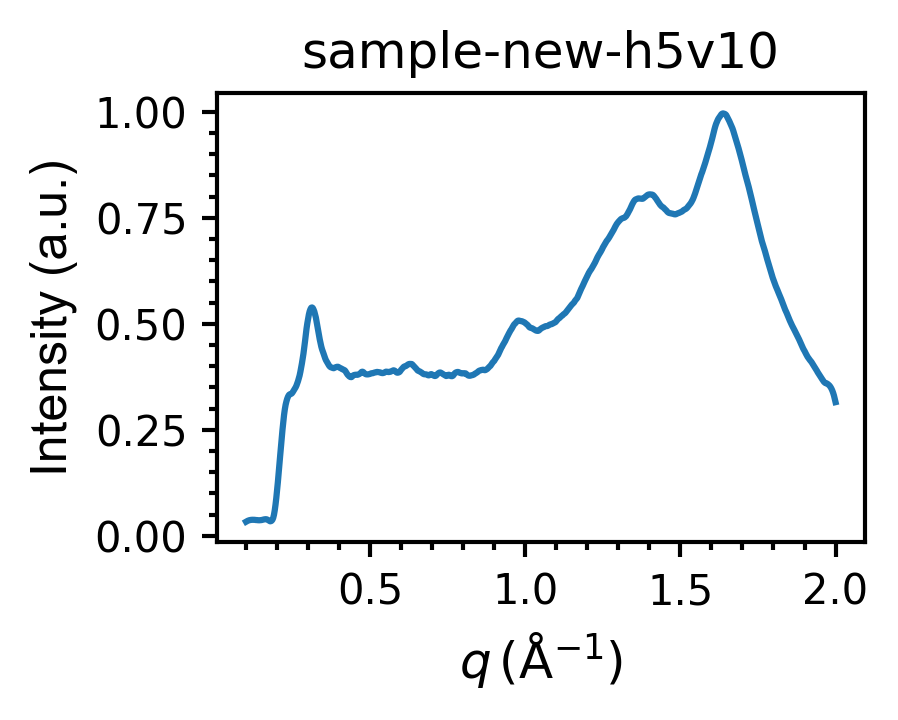

In [ ]:
qresolution = 0.0025
qmin = 0.1  # range of q map, in angstrom^-1
qmax = 2.0
chimin = 80
chimax = 90
denoise = True
intensity_max = 2000
smooth = True
# background subtraction
im = fabio.open(sampleName).data
bkg = fabio.open(background).data
imarray = im - bkg * subratio  # subtract the background
Npixelsy, Npixelsx = imarray.shape  # dector Y-axis X-axis
chipoints = int((chimax - chimin) / 0.5) + 1
qpoints = int((qmax - qmin) / qresolution) + 1
chi = np.linspace(chimin, chimax, chipoints)
q = np.linspace(qmax, qmin, qpoints)
chi, q = np.meshgrid(chi, q)
qr = q * np.sin(np.deg2rad(chi))
qz = q * np.cos(np.deg2rad(chi))
qxy_square = np.square(qr)
q_square = q * q
# constant
distancep = distance / pixelsize
cosai = np.cos(incidence)
sinai = np.sin(incidence)
coeff = 2 * np.pi / wavelength
tanai = np.tan(incidence)
qx = qz * sinai / cosai - q_square / 2 / coeff / cosai
sx_s = qx / coeff + cosai
sy_s = np.sqrt(qxy_square - np.square(qx)) * np.sign(chi) / coeff
sz_s = qz / coeff - sinai
# rotate matrix
R_rot = np.array([[cosai, 0, -sinai], [0, 1, 0], [sinai, 0, cosai]])
# l(lab frame)
rotated = np.dot(np.stack((sx_s, sy_s, sz_s), axis=-1), R_rot.T)
sxl, syl, szl = rotated[..., 0], rotated[..., 1], rotated[..., 2]
cosphi, sinphi = np.cos(hTilt), np.sin(hTilt)
cospsi, sinpsi = np.cos(vTilt), np.sin(vTilt)
d_rot = np.array([
            [cosphi*cospsi, -sinphi, -cosphi*sinpsi],
            [sinphi*cospsi,  cosphi, -sinphi*sinpsi],
            [      sinpsi,        0,         cospsi]
        ])
# s(sample frame)
a, b, c = d_rot.T @ np.array([1.0, 0.0, 0.0])
n = a * distancep / (-a * sxl + b * syl + c * szl)
xp = distancep + n * sxl
yp = -n * syl
zp = -n * szl
ry = d_rot[1, 0] * xp + d_rot[1, 1] * yp + d_rot[1, 2] * zp
rz = d_rot[2, 0] * xp + d_rot[2, 1] * yp + d_rot[2, 2] * zp
py = bcy - rz
px = ry + bcx
intensity = map_coordinates(imarray,
                            np.asarray([py, px]),
                            order=3)
if denoise:
    intensity = signal.medfilt2d(intensity, 3)
q1d = integrate.simpson(intensity, axis=1)
q1dnew = q1d / np.max(q1d)
if smooth:
    q1dnew = signal.savgol_filter(q1dnew, 25, 3)
x1d = q.T[0]
plt.figure(figsize=(3, 2.5), dpi=300)
params = {
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'axes.linewidth': 1,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1
}
plt.rcParams.update(params)
plt.title(sampleName.split('.')[0])
plt.plot(x1d, q1dnew)
ax = plt.gca()
plt.xlabel(r'$q\/(\mathrm{\AA}^{-1})$',
           fontsize=12,
           family="Arial")
plt.ylabel(r'Intensity (a.u.)', fontsize=12, family="Arial")
ax.minorticks_on()
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
plt.tight_layout()
# plt.savefig('q_'+sampleName.split('.')[0]+'.pdf')
# plt.colorbar()
plt.show()
